In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_simple as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_name = 'bert'
model_conf = confs.bert_conf
num_labels = 2

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,['about','to','as'],model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,['about','to','as'],model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,['about','to','as'],model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [14]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [15]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5589636009225447 	 Validation loss: 0.41424379358857366 	 
  1%|          | 574/57400 [01:40<2:32:44,  6.20it/s]
Epoch 2 	 Training loss: 0.3858783889938315 	 Validation loss: 0.35102001666012456 	 
  2%|▏         | 1148/57400 [03:18<3:00:54,  5.18it/s]
Epoch 3 	 Training loss: 0.34528492411877637 	 Validation loss: 0.33356487826775694 	 
  3%|▎         | 1722/57400 [04:57<2:22:13,  6.52it/s]
Epoch 4 	 Training loss: 0.32406353267746935 	 Validation loss: 0.32266253712823834 	 
  4%|▍         | 2296/57400 [06:36<2:40:32,  5.72it/s]
Epoch 5 	 Training loss: 0.308684567722917 	 Validation loss: 0.3160441275370323 	 
  5%|▌         | 2870/57400 [08:15<2:33:10,  5.93it/s]
Epoch 6 	 Training loss: 0.29532129548567926 	 Validation loss: 0.31023071428476756 	 
  6%|▌         | 3444/57400 [09:53<2:29:18,  6.02it/s]
Epoch 7 	 Training loss: 0.2825067559393441 	 Validation loss: 0.30428347521919313 	 
  7%|▋         | 4018/57400 [11:33<2:24:56,  6.14it/s]
Epoch 8 	 Tra

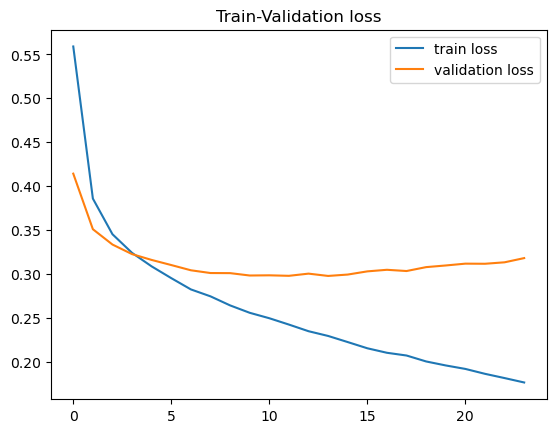

In [16]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [17]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8525, 'male': 0.8359375, 'average': 0.84421875}
precision {'female': 0.844059405940594, 'male': 0.8447368421052631, 'average': 0.8443981240229286}
f1 {'female': 0.8482587064676617, 'male': 0.8403141361256545, 'average': 0.8442864212966581}
accuracy 0.8443877551020408


Evaluación en el conjunto el conjunto to
recall {'female': 0.7191601049868767, 'male': 0.656934306569343, 'average': 0.6880472057781098}
precision {'female': 0.6602409638554216, 'male': 0.7161803713527851, 'average': 0.6882106676041033}
f1 {'female': 0.6884422110552764, 'male': 0.6852791878172588, 'average': 0.6868606994362676}
accuracy 0.6868686868686869


Evaluación en el conjunto el conjunto as
recall {'female': 0.6873315363881402, 'male': 0.6742424242424242, 'average': 0.6807869803152822}
precision {'female': 0.6640625, 'male': 0.6971279373368147, 'average': 0.6805952186684073}
f1 {'female': 0.6754966887417219, 'male': 0.6854942233632864, 'average': 0.

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5536334219709922 	 Validation loss: 0.39646891113054955 	 
  1%|          | 574/57400 [01:40<2:39:08,  5.95it/s]
Epoch 2 	 Training loss: 0.37666760115050274 	 Validation loss: 0.3464329990289979 	 
  2%|▏         | 1148/57400 [03:20<2:41:00,  5.82it/s]
Epoch 3 	 Training loss: 0.3423535726730832 	 Validation loss: 0.3302415041095119 	 
  3%|▎         | 1722/57400 [05:00<2:34:01,  6.02it/s]
Epoch 4 	 Training loss: 0.32133196167102673 	 Validation loss: 0.3192912476547694 	 
  4%|▍         | 2296/57400 [06:40<2:17:53,  6.66it/s]
Epoch 5 	 Training loss: 0.3073964824036854 	 Validation loss: 0.31292368749440724 	 
  5%|▌         | 2870/57400 [08:18<2:28:13,  6.13it/s]
Epoch 6 	 Training loss: 0.2947411215782996 	 Validation loss: 0.3084752251536159 	 
  6%|▌         | 3444/57400 [09:58<2:24:44,  6.21it/s]
Epoch 7 	 Training loss: 0.2835650117710908 	 Validation loss: 0.3057600231999058 	 
  7%|▋         | 4018/57400 [11:37<2:17:06,  6.49it/s]
Epoch 8 	 Trainin

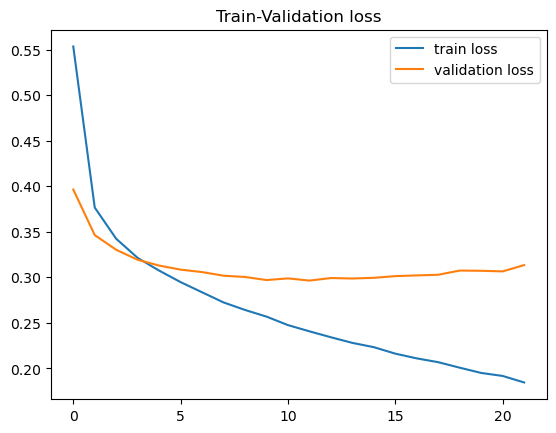

In [18]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [19]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.845, 'male': 0.8229166666666666, 'average': 0.8339583333333334}
precision {'female': 0.8325123152709359, 'male': 0.8359788359788359, 'average': 0.8342455756248859}
f1 {'female': 0.8387096774193549, 'male': 0.8293963254593176, 'average': 0.8340530014393363}
accuracy 0.8341836734693877


Evaluación en el conjunto el conjunto to
recall {'female': 0.7112860892388452, 'male': 0.6690997566909975, 'average': 0.6901929229649213}
precision {'female': 0.6658476658476659, 'male': 0.7142857142857143, 'average': 0.6900666900666901}
f1 {'female': 0.6878172588832487, 'male': 0.6909547738693467, 'average': 0.6893860163762977}
accuracy 0.6893939393939394


Evaluación en el conjunto el conjunto as
recall {'female': 0.6954177897574124, 'male': 0.6717171717171717, 'average': 0.683567480737292}
precision {'female': 0.6649484536082474, 'male': 0.7018469656992085, 'average': 0.6833977096537279}
f1 {'female': 0.6798418972332015, 'male': 0.68645

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5511964802023426 	 Validation loss: 0.40609051615504893 	 
  1%|          | 574/57400 [01:35<2:26:49,  6.45it/s]
Epoch 2 	 Training loss: 0.38128598937797215 	 Validation loss: 0.34785767328941214 	 
  2%|▏         | 1148/57400 [03:12<2:25:19,  6.45it/s]
Epoch 3 	 Training loss: 0.3433496473350591 	 Validation loss: 0.3321852873442537 	 
  3%|▎         | 1722/57400 [04:49<2:27:19,  6.30it/s]
Epoch 4 	 Training loss: 0.3241875300424024 	 Validation loss: 0.32393964342141557 	 
  4%|▍         | 2296/57400 [06:26<2:15:44,  6.77it/s]
Epoch 5 	 Training loss: 0.30785037270821763 	 Validation loss: 0.31471849548614633 	 
  5%|▌         | 2870/57400 [08:03<2:21:09,  6.44it/s]
Epoch 6 	 Training loss: 0.2952568499364919 	 Validation loss: 0.3090823967072923 	 
  6%|▌         | 3444/57400 [09:39<2:23:24,  6.27it/s]
Epoch 7 	 Training loss: 0.28479121866853396 	 Validation loss: 0.30602878079576007 	 
  7%|▋         | 4018/57400 [11:16<2:14:28,  6.62it/s]
Epoch 8 	 Tra

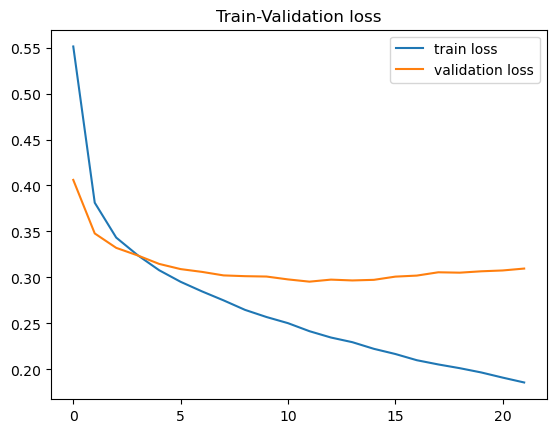

In [20]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [21]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8425, 'male': 0.8463541666666666, 'average': 0.8444270833333334}
precision {'female': 0.851010101010101, 'male': 0.8376288659793815, 'average': 0.8443194834947412}
f1 {'female': 0.8467336683417085, 'male': 0.8419689119170984, 'average': 0.8443512901294035}
accuracy 0.8443877551020408


Evaluación en el conjunto el conjunto to
recall {'female': 0.6876640419947506, 'male': 0.6958637469586375, 'average': 0.6917638944766941}
precision {'female': 0.6770025839793282, 'male': 0.7061728395061728, 'average': 0.6915877117427505}
f1 {'female': 0.6822916666666666, 'male': 0.7009803921568627, 'average': 0.6916360294117647}
accuracy 0.6919191919191919


Evaluación en el conjunto el conjunto as
recall {'female': 0.6792452830188679, 'male': 0.6843434343434344, 'average': 0.6817943586811511}
precision {'female': 0.6684350132625995, 'male': 0.6948717948717948, 'average': 0.6816534040671971}
f1 {'female': 0.6737967914438503, 'male': 0.6895

Resultados finales

In [22]:

print('f1 medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global F1:',mean(global_metrics[task]['f1']['average']))
    print(f'F1 etiqueta male:',mean(global_metrics[task]['f1']['male']))
    print('F1 etiqueta female: ',mean(global_metrics[task]['f1']['female']))

f1 medio de los 3 modelos: 


 about
Resultado global F1: 0.840896904288466
F1 etiqueta male: 0.8372264578340235
F1 etiqueta female:  0.8445673507429083

 to
Resultado global F1: 0.68929424840811
F1 etiqueta male: 0.6924047846144894
F1 etiqueta female:  0.6861837122017306

 as
Resultado global F1: 0.6817747739517885
F1 etiqueta male: 0.6871710887639858
F1 etiqueta female:  0.6763784591395913


In [23]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.840896904288466
f1 etiqueta male: 0.8372264578340235
f1 etiqueta female:  0.8445673507429083


TO
Resultado global f1: 0.68929424840811
f1 etiqueta male: 0.6924047846144894
f1 etiqueta female:  0.6861837122017306


AS
Resultado global f1: 0.6817747739517885
f1 etiqueta male: 0.6871710887639858
f1 etiqueta female:  0.6763784591395913


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.840896904288466
recall etiqueta male: 0.8372264578340235
recall etiqueta female:  0.8445673507429083


TO
Resultado global recall: 0.68929424840811
recall etiqueta male: 0.6924047846144894
recall etiqueta female:  0.6861837122017306


AS
Resultado global recall: 0.6817747739517885
recall etiqueta male: 0.6871710887639858
recall etiqueta female:  0.6763784591395913


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.840896904288466
precision etiqueta male: 0.8372264578340235
precision etiqueta female:  0.84456735

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7000246002283661 	 Validation loss: 0.6926935911178589 	 
  1%|          | 574/57400 [01:37<2:48:35,  5.62it/s]
Epoch 2 	 Training loss: 0.6991664575159757 	 Validation loss: 0.6942112203371726 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:14<2:30:29,  6.23it/s]
Epoch 3 	 Training loss: 0.6989321081480498 	 Validation loss: 0.6934297206038136 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:51<2:28:36,  6.24it/s]
Epoch 4 	 Training loss: 0.6981664660292636 	 Validation loss: 0.6923465021586014 	 
  4%|▍         | 2296/57400 [06:30<2:24:19,  6.36it/s]
Epoch 5 	 Training loss: 0.6980410956547235 	 Validation loss: 0.6931780081684307 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:07<2:39:26,  5.70it/s]
Epoch 6 	 Training loss: 0.6974482394053961 	 Validation loss: 0.6939608192039748 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [09:44<2:52:30,  5.21it/s]
Epoch 7 	 Training loss: 0.6973541575234111 	

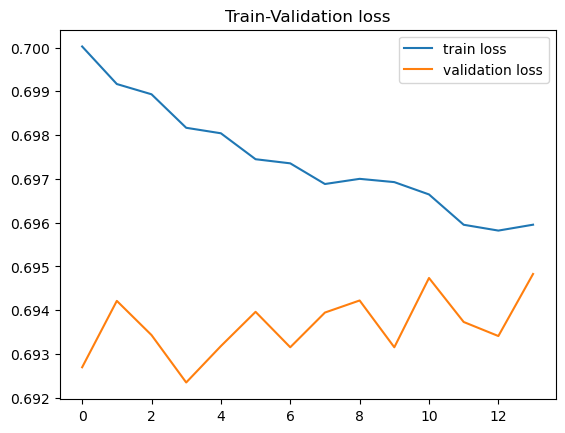

In [25]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [26]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.5925, 'male': 0.4609375, 'average': 0.52671875}
precision {'female': 0.5337837837837838, 'male': 0.5205882352941177, 'average': 0.5271860095389507}
f1 {'female': 0.5616113744075829, 'male': 0.48895027624309395, 'average': 0.5252808253253385}
accuracy 0.5280612244897959


Evaluación en el conjunto el conjunto to
recall {'female': 0.48031496062992124, 'male': 0.5474452554744526, 'average': 0.5138801080521869}
precision {'female': 0.4959349593495935, 'male': 0.5319148936170213, 'average': 0.5139249264833073}
f1 {'female': 0.488, 'male': 0.5395683453237411, 'average': 0.5137841726618706}
accuracy 0.5151515151515151


Evaluación en el conjunto el conjunto as
recall {'female': 0.5256064690026954, 'male': 0.43434343434343436, 'average': 0.47997495167306486}
precision {'female': 0.46539379474940334, 'male': 0.4942528735632184, 'average': 0.47982333415631084}
f1 {'female': 0.49367088607594933, 'male': 0.46236559139784944, 'averag

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7022806497401062 	 Validation loss: 0.6948110673387172 	 
  1%|          | 574/57400 [01:37<2:27:17,  6.43it/s]
Epoch 2 	 Training loss: 0.6982318735081144 	 Validation loss: 0.6940742236072734 	 
  2%|▏         | 1148/57400 [03:15<2:32:17,  6.16it/s]
Epoch 3 	 Training loss: 0.6971094019529296 	 Validation loss: 0.6920924408961151 	 
  3%|▎         | 1722/57400 [04:53<2:37:11,  5.90it/s]
Epoch 4 	 Training loss: 0.6960934772308696 	 Validation loss: 0.6929982173240791 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:30<2:24:03,  6.37it/s]
Epoch 5 	 Training loss: 0.6966247490058792 	 Validation loss: 0.6922173459651106 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:07<2:31:55,  5.98it/s]
Epoch 6 	 Training loss: 0.6969962327737842 	 Validation loss: 0.6929577467805248 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:43<2:29:15,  6.03it/s]
Epoch 7 	 Training loss: 0.6963033625265447 	 Validation loss: 0.693905950

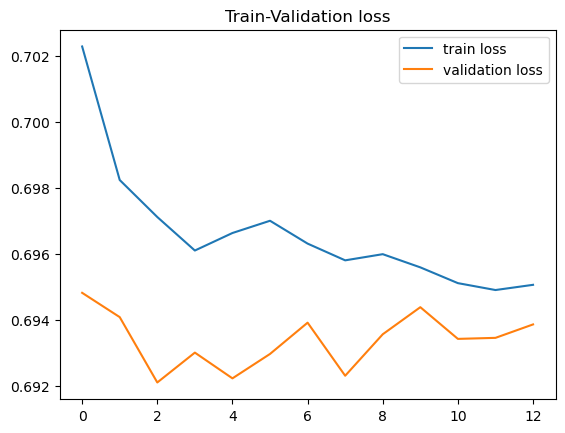

In [27]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_to2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8125, 'male': 0.16927083333333334, 'average': 0.4908854166666667}
precision {'female': 0.5046583850931677, 'male': 0.4642857142857143, 'average': 0.484472049689441}
f1 {'female': 0.6226053639846744, 'male': 0.2480916030534351, 'average': 0.43534848351905475}
accuracy 0.49744897959183676


Evaluación en el conjunto el conjunto to
recall {'female': 0.8503937007874016, 'male': 0.1922141119221411, 'average': 0.5213039063547713}
precision {'female': 0.49390243902439024, 'male': 0.5808823529411765, 'average': 0.5373923959827833}
f1 {'female': 0.6248794599807136, 'male': 0.28884826325411334, 'average': 0.45686386161741344}
accuracy 0.5088383838383839


Evaluación en el conjunto el conjunto as
recall {'female': 0.8490566037735849, 'male': 0.17676767676767677, 'average': 0.5129121402706308}
precision {'female': 0.4914196567862715, 'male': 0.5555555555555556, 'average': 0.5234876061709135}
f1 {'female': 0.6225296442687748, 'male':

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7001454051363344 	 Validation loss: 0.6934705134165489 	 
  1%|          | 574/57400 [01:37<2:32:00,  6.23it/s]
Epoch 2 	 Training loss: 0.6952896485760652 	 Validation loss: 0.6920782489291692 	 
  2%|▏         | 1148/57400 [03:14<2:30:23,  6.23it/s]
Epoch 3 	 Training loss: 0.6945457291312334 	 Validation loss: 0.6938789001965927 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:51<2:27:58,  6.27it/s]
Epoch 4 	 Training loss: 0.6942871056159614 	 Validation loss: 0.6937083965640957 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:28<2:31:06,  6.08it/s]
Epoch 5 	 Training loss: 0.6941624054302322 	 Validation loss: 0.6926731921858706 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [08:05<2:24:30,  6.29it/s]
Epoch 6 	 Training loss: 0.6937428533200187 	 Validation loss: 0.6939786399825144 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [09:43<2:30:24,  5.98it/s]
Epoch 7 	 Training loss: 0.6937404813874474 	

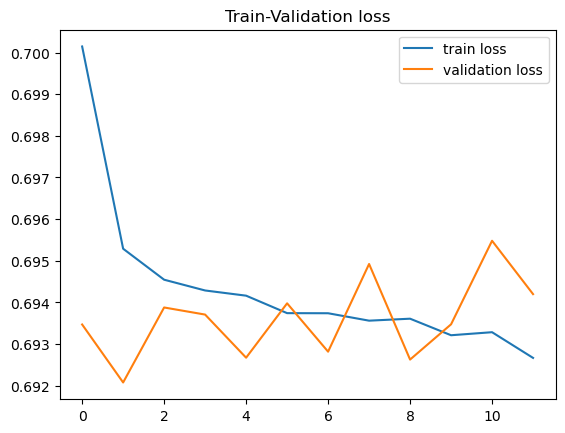

In [29]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_to3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [30]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.805, 'male': 0.296875, 'average': 0.5509375000000001}
precision {'female': 0.543918918918919, 'male': 0.59375, 'average': 0.5688344594594594}
f1 {'female': 0.6491935483870968, 'male': 0.3958333333333333, 'average': 0.522513440860215}
accuracy 0.5561224489795918


Evaluación en el conjunto el conjunto to
recall {'female': 0.7506561679790026, 'male': 0.34793187347931875, 'average': 0.5492940207291607}
precision {'female': 0.516245487364621, 'male': 0.6008403361344538, 'average': 0.5585429117495373}
f1 {'female': 0.6117647058823529, 'male': 0.4406779661016949, 'average': 0.5262213359920239}
accuracy 0.5416666666666666


Evaluación en el conjunto el conjunto as
recall {'female': 0.6900269541778976, 'male': 0.3686868686868687, 'average': 0.5293569114323832}
precision {'female': 0.5059288537549407, 'male': 0.5593869731800766, 'average': 0.5326579134675087}
f1 {'female': 0.5838084378563284, 'male': 0.4444444444444444, 'average'

Resultados finales

In [31]:

for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.49438091656820277
f1 etiqueta male: 0.3776250708766208
f1 etiqueta female:  0.6111367622597846


TO
Resultado global f1: 0.49895645675710265
f1 etiqueta male: 0.42303152489318313
f1 etiqueta female:  0.5748813886210221


AS
Resultado global f1: 0.4791697062933036
f1 etiqueta male: 0.39166975651958963
f1 etiqueta female:  0.5666696560670175


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.49438091656820277
recall etiqueta male: 0.3776250708766208
recall etiqueta female:  0.6111367622597846


TO
Resultado global recall: 0.49895645675710265
recall etiqueta male: 0.42303152489318313
recall etiqueta female:  0.5748813886210221


AS
Resultado global recall: 0.4791697062933036
recall etiqueta male: 0.39166975651958963
recall etiqueta female:  0.5666696560670175


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.49438091656820277
precision etiqueta male: 0.3776250708766208
precision etiqueta fem

# AS

In [32]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6976840018395347 	 Validation loss: 0.693230246083211 	 
  1%|          | 574/57400 [01:37<2:33:22,  6.18it/s]
Epoch 2 	 Training loss: 0.6948987274635129 	 Validation loss: 0.692987649117486 	 
  2%|▏         | 1148/57400 [03:16<2:29:10,  6.28it/s]
Epoch 3 	 Training loss: 0.6941771156281129 	 Validation loss: 0.6917749117996733 	 
  3%|▎         | 1722/57400 [04:54<2:17:47,  6.73it/s]
Epoch 4 	 Training loss: 0.693769009167309 	 Validation loss: 0.6950653649992862 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:31<2:22:36,  6.44it/s]
Epoch 5 	 Training loss: 0.6938209693606306 	 Validation loss: 0.6937798190925081 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:09<2:59:16,  5.07it/s]
Epoch 6 	 Training loss: 0.6935746684307005 	 Validation loss: 0.6937762135166233 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:46<2:17:27,  6.54it/s]
Epoch 7 	 Training loss: 0.6933903496855227 	 Validation loss: 0.691891224707

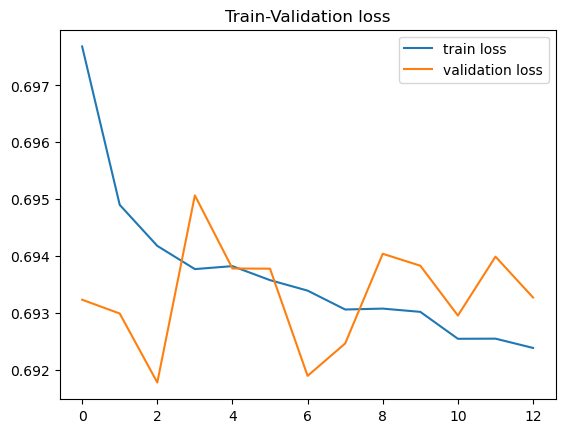

In [33]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_as'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.925, 'male': 0.16666666666666666, 'average': 0.5458333333333334}
precision {'female': 0.5362318840579711, 'male': 0.6808510638297872, 'average': 0.6085414739438791}
f1 {'female': 0.6788990825688074, 'male': 0.2677824267782427, 'average': 0.47334075467352504}
accuracy 0.5535714285714286


Evaluación en el conjunto el conjunto to
recall {'female': 0.8923884514435696, 'male': 0.19951338199513383, 'average': 0.5459509167193517}
precision {'female': 0.5082212257100149, 'male': 0.6666666666666666, 'average': 0.5874439461883407}
f1 {'female': 0.6476190476190475, 'male': 0.3071161048689139, 'average': 0.47736757624398074}
accuracy 0.5328282828282829


Evaluación en el conjunto el conjunto as
recall {'female': 0.9056603773584906, 'male': 0.18686868686868688, 'average': 0.5462645321135887}
precision {'female': 0.5106382978723404, 'male': 0.6788990825688074, 'average': 0.5947686902205739}
f1 {'female': 0.6530612244897959, 'male': 0

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6988286405074887 	 Validation loss: 0.6925154338448735 	 
  1%|          | 574/57400 [01:38<2:32:18,  6.22it/s]
Epoch 2 	 Training loss: 0.6982540769651792 	 Validation loss: 0.6938328530828831 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:15<2:24:38,  6.48it/s]
Epoch 3 	 Training loss: 0.697166358552328 	 Validation loss: 0.6933738255904893 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:54<2:28:46,  6.24it/s]
Epoch 4 	 Training loss: 0.6973192338744107 	 Validation loss: 0.69279206809351 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [06:32<2:36:31,  5.87it/s]
Epoch 5 	 Training loss: 0.6968916867460523 	 Validation loss: 0.6946080215906693 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:09<2:19:27,  6.52it/s]
Epoch 6 	 Training loss: 0.6971572373802238 	 Validation loss: 0.6925038634720495 	 
  6%|▌         | 3444/57400 [09:48<2:25:50,  6.17it/s]
Epoch 7 	 Training loss: 0.696029341490842 	 Val

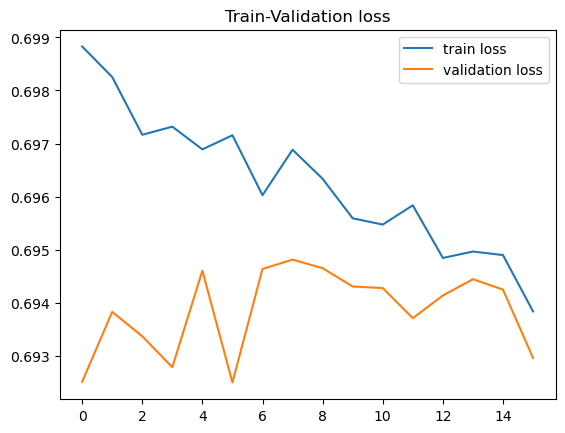

In [35]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_as2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.775, 'male': 0.4036458333333333, 'average': 0.5893229166666667}
precision {'female': 0.575139146567718, 'male': 0.6326530612244898, 'average': 0.6038961038961039}
f1 {'female': 0.6602768903088393, 'male': 0.49284578696343406, 'average': 0.5765613386361367}
accuracy 0.5931122448979592


Evaluación en el conjunto el conjunto to
recall {'female': 0.6850393700787402, 'male': 0.45255474452554745, 'average': 0.5687970573021438}
precision {'female': 0.5370370370370371, 'male': 0.6078431372549019, 'average': 0.5724400871459695}
f1 {'female': 0.6020761245674742, 'male': 0.5188284518828451, 'average': 0.5604522882251597}
accuracy 0.5643939393939394


Evaluación en el conjunto el conjunto as
recall {'female': 0.7304582210242587, 'male': 0.3939393939393939, 'average': 0.5621988074818263}
precision {'female': 0.5303326810176126, 'male': 0.609375, 'average': 0.5698538405088063}
f1 {'female': 0.6145124716553287, 'male': 0.4785276073619

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6970316963951763 	 Validation loss: 0.6950711658445455 	 
  1%|          | 574/57400 [01:37<2:30:06,  6.31it/s]
Epoch 2 	 Training loss: 0.6949242168602627 	 Validation loss: 0.6930047172611042 	 
  2%|▏         | 1148/57400 [03:15<2:38:46,  5.90it/s]
Epoch 3 	 Training loss: 0.6937568520004326 	 Validation loss: 0.6915788074671212 	 
  3%|▎         | 1722/57400 [04:52<2:22:15,  6.52it/s]
Epoch 4 	 Training loss: 0.6935755717422073 	 Validation loss: 0.6925916469703286 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:30<2:29:21,  6.15it/s]
Epoch 5 	 Training loss: 0.6932645944768128 	 Validation loss: 0.6942440321889974 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:07<2:25:13,  6.26it/s]
Epoch 6 	 Training loss: 0.6932049587836249 	 Validation loss: 0.6944975772146451 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:44<2:18:42,  6.48it/s]
Epoch 7 	 Training loss: 0.6929567835264505 	 Validation loss: 0.693185547

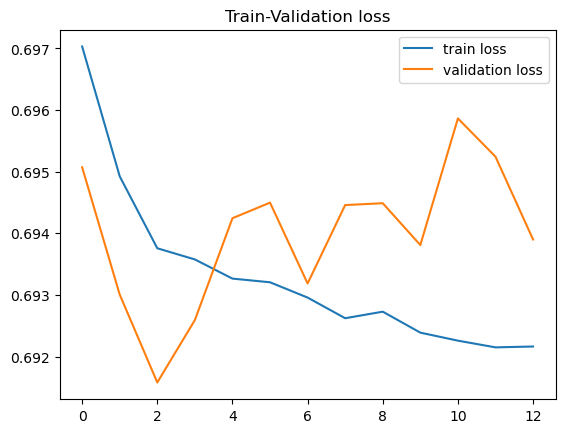

In [37]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_as3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8125, 'male': 0.23177083333333334, 'average': 0.5221354166666666}
precision {'female': 0.5241935483870968, 'male': 0.5426829268292683, 'average': 0.5334382376081825}
f1 {'female': 0.6372549019607843, 'male': 0.3248175182481752, 'average': 0.4810362101044797}
accuracy 0.5280612244897959


Evaluación en el conjunto el conjunto to
recall {'female': 0.8530183727034121, 'male': 0.15571776155717762, 'average': 0.5043680671302948}
precision {'female': 0.4836309523809524, 'male': 0.5333333333333333, 'average': 0.5084821428571429}
f1 {'female': 0.6172839506172839, 'male': 0.24105461393596986, 'average': 0.4291692822766269}
accuracy 0.4911616161616162


Evaluación en el conjunto el conjunto as
recall {'female': 0.8059299191374663, 'male': 0.2398989898989899, 'average': 0.522914454518228}
precision {'female': 0.49833333333333335, 'male': 0.5688622754491018, 'average': 0.5335978043912176}
f1 {'female': 0.615859938208033, 'male': 0.3

Resultados finales

In [39]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5103127678047138
f1 etiqueta male: 0.3618152439966173
f1 etiqueta female:  0.6588102916128104


TO
Resultado global f1: 0.4889963822485891
f1 etiqueta male: 0.35566639022924296
f1 etiqueta female:  0.6223263742679352


AS
Resultado global f1: 0.49875139102652255
f1 etiqueta male: 0.3696915706019926
f1 etiqueta female:  0.6278112114510526


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5103127678047138
recall etiqueta male: 0.3618152439966173
recall etiqueta female:  0.6588102916128104


TO
Resultado global recall: 0.4889963822485891
recall etiqueta male: 0.35566639022924296
recall etiqueta female:  0.6223263742679352


AS
Resultado global recall: 0.49875139102652255
recall etiqueta male: 0.3696915706019926
recall etiqueta female:  0.6278112114510526


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5103127678047138
precision etiqueta male: 0.3618152439966173
precision etiqueta female: 